# 2 Exploring Dataset Charateristics with resample exposure

In this notebook we will cover a few examples of how using our method as a measure of similarity, highlights certain charateristics of the dataset under investigation.

[0.28066586 0.27381302 0.26696017 0.26598441 0.26754    0.2670635
 0.26783984 0.26850055 0.26972462 0.27595623 0.27693543 0.27504002
 0.27883505 0.28367776 0.28706247 0.28516707 0.28997257 0.29727333
 0.27509738 0.27348276 0.26713309 0.26312169 0.26373414 0.26515345
 0.26902868 0.27852049 0.2809316  0.28383016 0.28688009 0.29646138] [0]


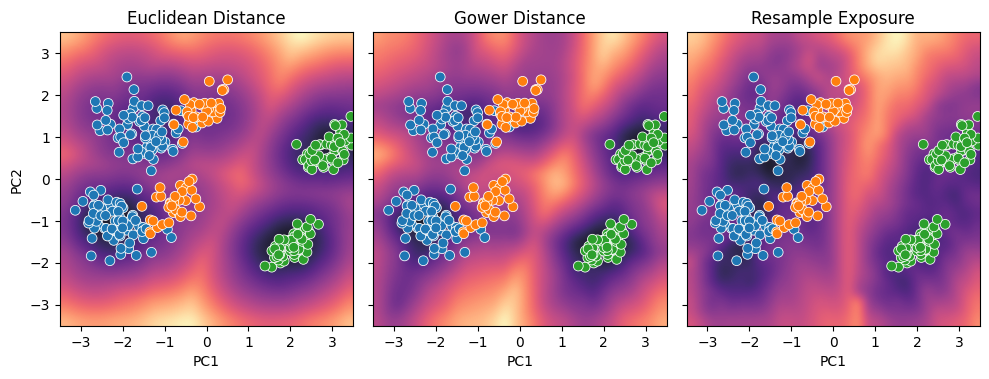

In [ ]:
### heatmap of exposure
# We project the dataset into the principal component space

import gower

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from experiments.prepare_data import preprocess_data
from rex_score.resample_exposure import ResampleExposure

df = sns.load_dataset('penguins').dropna()
df,_,_ = preprocess_data(df, 'species')

def plot_heatmap_exposure(df):

    # project onto the first two principal components
    pca = PCA(n_components=2)

    X = df.select_dtypes(include=[np.number])
    X_std = (X - X.mean()) / X.std()  # standardize the data
    X_pca = pca.fit_transform(X_std)

    # gram coordinates in the PCA space and transform them to the original space
    x_lspace = np.linspace(-3.5, 3.5, 30)
    y_lspace = np.linspace(-3.5, 3.5, 30)

    # transform the grid to the PCA space
    X_grid, Y_grid = np.meshgrid(x_lspace, y_lspace)
    grid_points = np.c_[X_grid.ravel(), Y_grid.ravel()]
    grid_points_transformed = pca.inverse_transform(grid_points)

    # calculate the resample exposure of the grid points
    rex = ResampleExposure(X_std)
    exposure = np.zeros(grid_points_transformed.shape[0])
    distances = np.zeros(grid_points_transformed.shape[0])
    gower_dists = np.zeros(grid_points_transformed.shape[0])
    for i, point in enumerate(grid_points_transformed):
        point_df = pd.DataFrame([point], columns=X.columns)
        exposure[i] = np.min(1-rex.resample_exposure_matrix(point_df, True))
        distances[i] = np.min(np.linalg.norm(X_std - point_df.values, axis=1))
        gower_dists[i] = np.min(gower.gower_matrix(point_df, X_std))

    ### plotting the results
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), sharex=True, sharey=True)
    for i, ax in enumerate(fig.axes):
        ax.set_aspect('equal')
        ax.set_xlabel('PC1')
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['class'], palette='tab10', s=50, ax=ax)
    
    # plot the equidistant contours for eucledian distance from the source point
    ax = fig.axes[0]
    ax.set_ylabel('PC2')
    distance_grid = distances.reshape(X_grid.shape)
    distance_map = ax.imshow(distance_grid, extent=(-3.5, 3.5, -3.5, 3.5), origin='lower', cmap='magma', alpha=0.9, interpolation='bicubic')
    ax.axis([-3.5, 3.5, -3.5, 3.5])
    ax.get_legend().remove()
    ax.set_title('Euclidean Distance')

    # plot the gower distance contours
    ax = fig.axes[1]
    gower_grid = gower_dists.reshape(X_grid.shape)
    gower_map = ax.imshow(gower_grid, extent=(-3.5, 3.5, -3.5, 3.5), origin='lower', cmap='magma', alpha=0.9, interpolation='bicubic')
    ax.axis([-3.5, 3.5, -3.5, 3.5])
    ax.get_legend().remove()
    ax.set_title('Gower Distance')

    # plot the resample exposure contours
    ax = fig.axes[2]
    exposure_grid = exposure.reshape(X_grid.shape)
    exposure_map = ax.imshow(exposure_grid, extent=(-3.5, 3.5, -3.5, 3.5), origin='lower', cmap='magma', alpha=0.9, interpolation='bicubic')
    ax.axis([-3.5, 3.5, -3.5, 3.5])
    ax.get_legend().remove()
    ax.set_title('Resample Exposure')

    print(exposure_grid[0],[0])
    plt.tight_layout()
    plt.show()

plot_heatmap_exposure(df)
# 0.28066586 0.27381302 0.26696017 0.26598441 0.26754    0.2670635

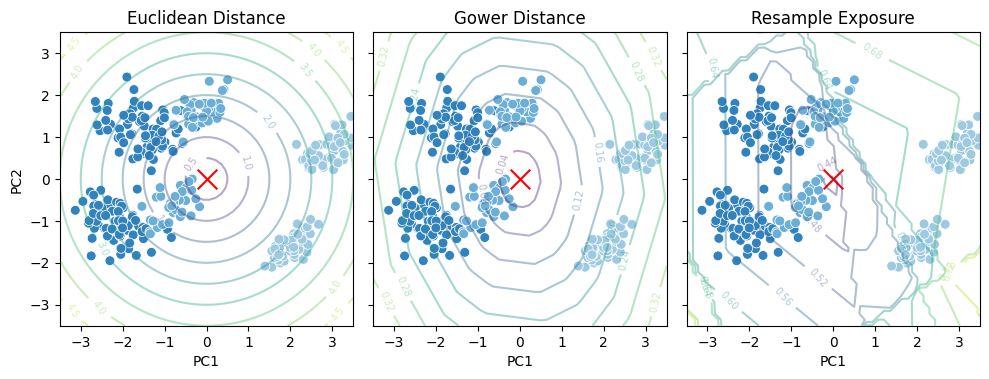

In [ ]:
import gower

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from experiments.prepare_data import preprocess_data
from rex_score.resample_exposure import ResampleExposure

df = sns.load_dataset('penguins').dropna()
df,_,_ = preprocess_data(df, 'species')

def plot_contour_source_exposure(df, source_point=[0, 0]):  
    """ Plot a contour map of resample exposure in PCA space, centered around a source point.
    Args:
        df (pd.DataFrame): DataFrame containing the dataset.
        source_point (list): Coordinates of the source point in PCA space.
    """
    pca = PCA(n_components=2)

    X = df.select_dtypes(include=[np.number])
    X_std = (X - X.mean()) / X.std()  # standardize the data
    X_pca = pca.fit_transform(X_std)

    # generate coordinates in the PCA space and transform them to the original space
    x_lspace = np.linspace(-3.5, 3.5, 50)
    y_lspace = np.linspace(-3.5, 3.5, 50)
    
    # transform the grid to the PCA space
    X_grid, Y_grid = np.meshgrid(x_lspace, y_lspace)
    grid_points = np.c_[X_grid.ravel(), Y_grid.ravel()]
    grid_points_transformed = pca.inverse_transform(grid_points)
    grid_df = pd.DataFrame(grid_points_transformed, columns=X.columns)
    source_point_data = pca.inverse_transform(source_point)
    point_df = pd.DataFrame([source_point_data], columns=X.columns)

    # calculate the euclidean distance from the source point to each grid point
    distances = np.linalg.norm(grid_points_transformed - np.array(source_point_data), axis=1)

    # calculate the gowers similarity for the grid points
    gower_distances = gower.gower_matrix(point_df, grid_df)

    # calculate the resample exposure of the grid points
    rex = ResampleExposure(X_std)
    rex.memorised_distribution = grid_df
    exposure = 1-rex.resample_exposure_matrix(point_df, True)

    ### Plotting the results
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), sharex=True, sharey=True)
    for i, ax in enumerate(fig.axes):
        ax.set_aspect('equal')
        ax.set_xlabel('PC1')
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['class'], palette='tab20c', s=50, ax=ax)
        ax.scatter(source_point[0], source_point[1], color='red', s=200, label='Source Point', marker='x')
    
    # plot the equidistant contours for eucledian distance from the source point
    ax = fig.axes[0]
    ax.set_ylabel('PC2')
    distance_grid = distances.reshape(X_grid.shape)
    contour_distance = ax.contour(X_grid, Y_grid, distance_grid, levels=10, cmap='viridis', alpha=0.4)
    ax.clabel(contour_distance, contour_distance.levels, fontsize=7)
    ax.axis([-3.5, 3.5, -3.5, 3.5])
    ax.get_legend().remove()
    ax.set_title('Euclidean Distance')

    # plot the gower distance contours
    ax = fig.axes[1]
    gower_grid = gower_distances.reshape(X_grid.shape)
    contour_gower = ax.contour(X_grid, Y_grid, gower_grid, levels=10, cmap='viridis', alpha=0.4)
    ax.clabel(contour_gower, contour_gower.levels, fontsize=7)
    ax.axis([-3.5, 3.5, -3.5, 3.5])
    ax.get_legend().remove()
    ax.set_title('Gower Distance')

    # plot the resample exposure contours
    ax = fig.axes[2]
    exposure_grid = exposure.reshape(X_grid.shape)
    contour = plt.contour(X_grid, Y_grid, exposure_grid, levels=10, cmap='viridis', alpha=0.4)
    ax.clabel(contour, contour.levels, fontsize=7)
    ax.axis([-3.5, 3.5, -3.5, 3.5])
    ax.get_legend().remove()
    ax.set_title('Resample Exposure')

    plt.tight_layout()
    plt.show()

plot_contour_source_exposure(df, source_point=[0, 0])

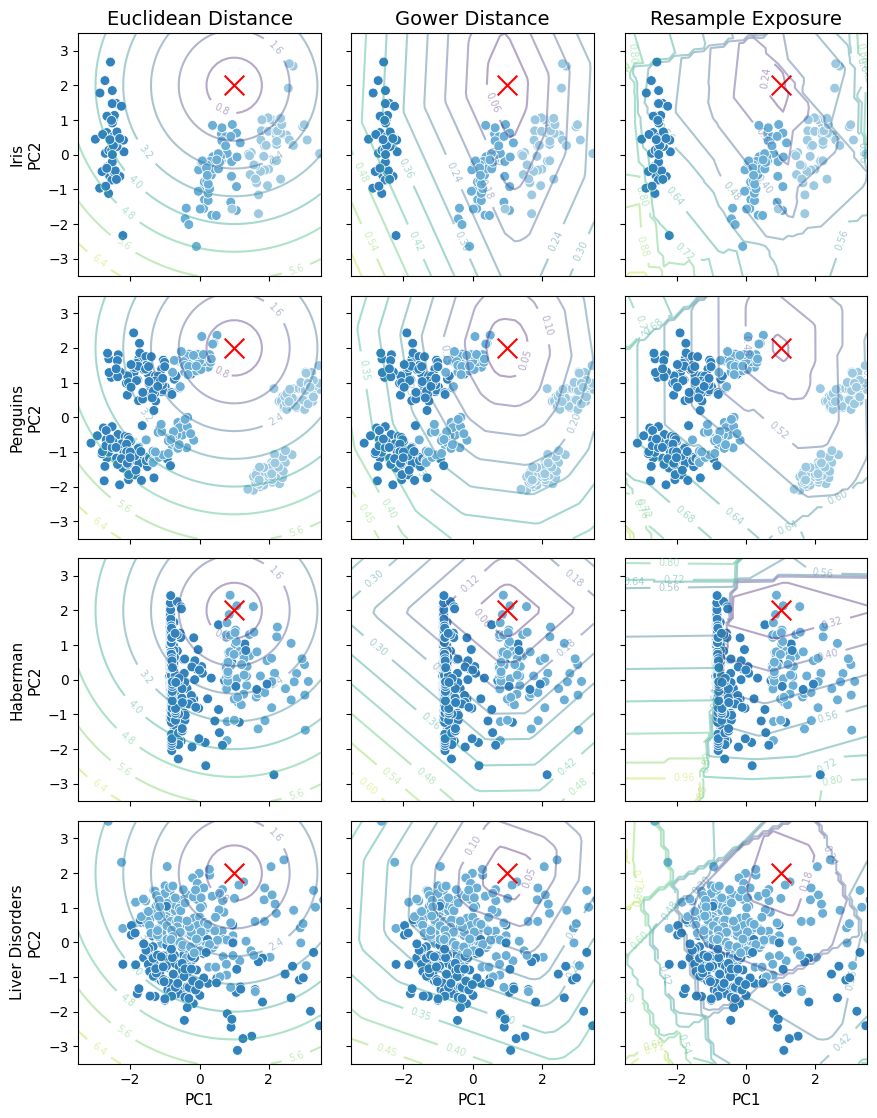

In [3]:
from experiments.plots import plot_multi_dataset_contour_comparison

import seaborn as sns
import uci_dataset as dataset
from experiments.prepare_data import preprocess_data, uci_dataset_id_import

df_iris = sns.load_dataset('iris')
df_iris,_,_ = preprocess_data(df_iris, 'species')

df_penguins = sns.load_dataset('penguins')
df_penguins,_,_ = preprocess_data(df_penguins, 'species')

df_haberman = dataset.load_haberman()
df_haberman, _, _ = preprocess_data(df_haberman, 'survival')

df_liver = dataset.load_liver_disorders()
df_liver, _, _ = preprocess_data(df_liver, 'selector')

datasets_dict = {
    "Iris": df_iris,
    "Penguins": df_penguins,
    "Haberman": df_haberman,
    "Liver Disorders": df_liver,
    }

plot_multi_dataset_contour_comparison(datasets_dict, source_point_pca=[1,2])

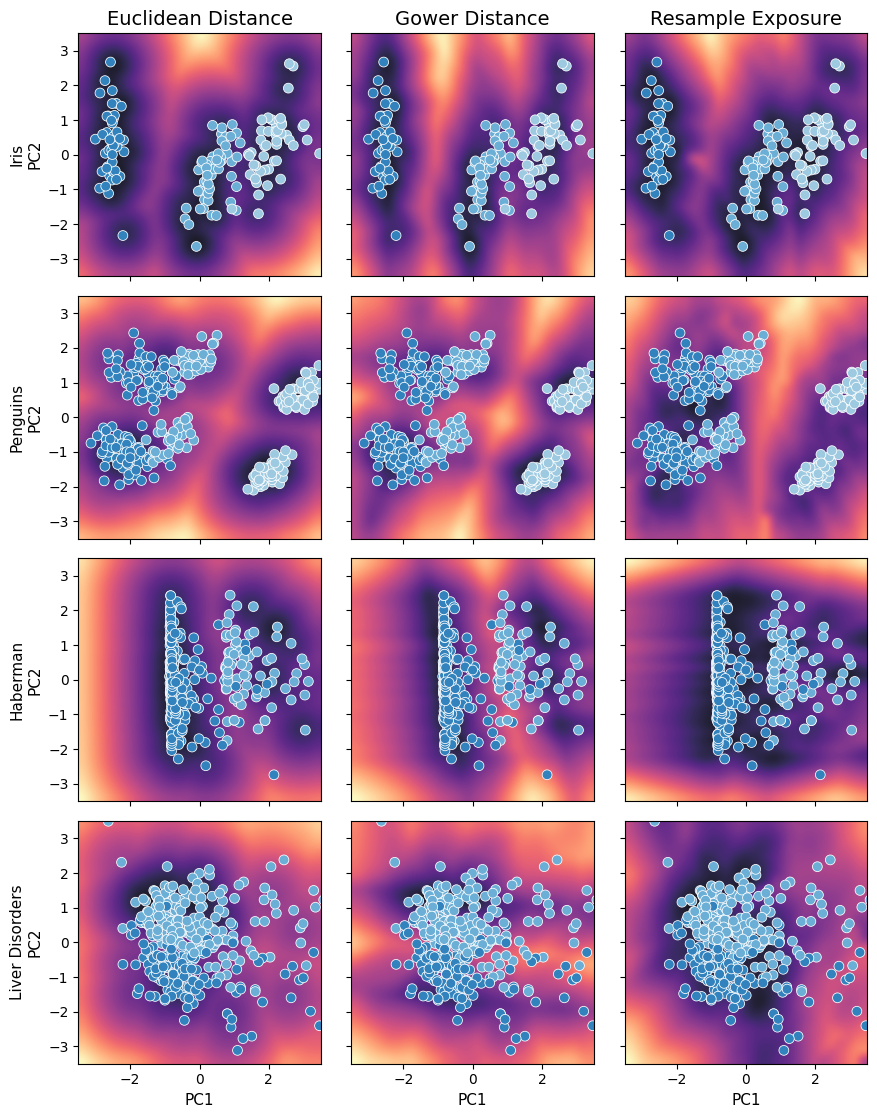

In [ ]:
from experiments.plots import plot_multi_dataset_heatmap_comparison

plot_multi_dataset_heatmap_comparison(datasets_dict)

## 2.1 Dataset characteristics
The following example considers the adult dataset, which is a collection of information about individuals, including their age, education, occupation, and income. The dataset is often used for classification tasks, such as predicting whether an individual earns more or less than $50,000 per year based on their attributes.

**The dataset is available at: https://archive.ics.uci.edu/ml/datasets/adult**

In [ ]:
from experiments.prepare_data import uci_dataset_id_import, preprocess_data

df = uci_dataset_id_import(2, silent_import=False)
df = df.sample(1000, random_state=42).reset_index(drop=True)

# df_enc = preprocess_data(df, 'class')

df.head()

Dataset Name: Adult


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,18,Private,423024,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,20,United-States,<=50K
1,17,Private,178953,12th,8,Never-married,Sales,Own-child,White,Female,0,0,20,United-States,<=50K
2,25,Local-gov,348986,HS-grad,9,Never-married,Handlers-cleaners,Other-relative,Black,Male,0,0,40,United-States,<=50K
3,20,Private,218215,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,United-States,<=50K
4,47,Private,244025,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,Amer-Indian-Eskimo,Male,0,0,56,Puerto-Rico,<=50K


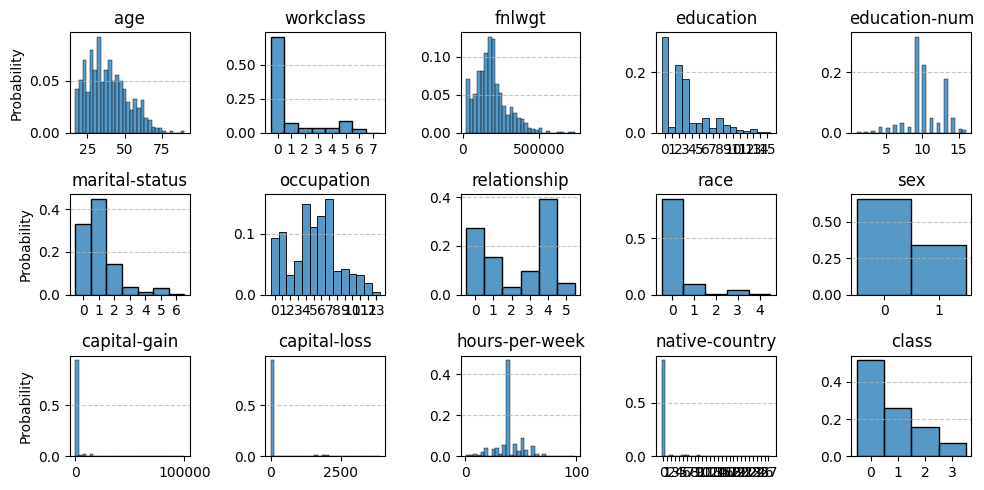

In [ ]:
# plot the distributions of each variable
from experiments.plots import plot_distributions

plot_distributions(df)

In this plot we can see that there is quite the difference in the distribution of each variable. [Our Metric] captures this difference as the weight in how probable it is to resample the query into the source record. E.g. it is much more probable to resample to the country of the United States than the country of the Philippines, since the united states is the most frequent level in the native-country variable. Why is this important? Well, because from the perspective of an adversary with access to an anonymised dataset, resampling the rarer levels of a variable into more frequent levels is a surefire way to increase the likelihood of reidentification (the opposite argument is also viable, but is less likely to suceed). 

In [ ]:
import pandas as pd
from experiments.KNN_adapters import REX_KNN

NN = REX_KNN()
NN.fit_nn(df)

query = df.iloc[0:1]

dist, nbrs = NN.get_neighbors(query, 5)

print(f"Distances: {dist}")

df.iloc[nbrs[0]]

MemoryError: Unable to allocate 3.69 TiB for an array with shape (712495, 712495) and data type float64

In [32]:
NN = REX_KNN()
NN.fit_nn(df)

query = df.iloc[4:5]

dist, nbrs = NN.get_neighbors(query, 5)

print(f"Distances: {dist}")

df.iloc[nbrs[0]]

Distances: [[0.         0.33333333 0.4        0.4        0.4       ]]


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
4,47,Private,244025,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,Amer-Indian-Eskimo,Male,0,0,56,Puerto-Rico,<=50K
446,21,Private,221955,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,White,Male,0,0,40,Mexico,<=50K
637,27,Private,156266,HS-grad,9,Never-married,Sales,Own-child,Amer-Indian-Eskimo,Male,0,0,20,United-States,<=50K
362,24,Private,152724,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,Black,Male,0,0,40,United-States,<=50K.
600,21,Private,184568,HS-grad,9,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [ ]:
df_rc_nc = df[(df['race'] == 'Amer-Indian-Eskimo') & (df['native-country'] == 'Puerto-Rico')]
df_rc_nc.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
4,47,Private,244025,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,Amer-Indian-Eskimo,Male,0,0,56,Puerto-Rico,<=50K


In [ ]:
df_mexi = df[(df['native-country'] == 'Mexico')]
print(len(df_mexi))

df_aie = df[(df['race'] == 'Amer-Indian-Eskimo')]
print(len(df_aie))

16
9


In [34]:
NN = REX_KNN()
NN.fit_nn(df)

query = df.iloc[2:3]

dist, nbrs = NN.get_neighbors(query, 5)

print(f"Distances: {dist}")

df.iloc[nbrs[0]]

Distances: [[0.         0.26666667 0.26666667 0.26666667 0.33333333]]


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
2,25,Local-gov,348986,HS-grad,9,Never-married,Handlers-cleaners,Other-relative,Black,Male,0,0,40,United-States,<=50K
135,25,Private,397962,HS-grad,9,Never-married,Adm-clerical,Other-relative,Black,Female,0,0,40,United-States,<=50K
764,24,Private,279041,HS-grad,9,Never-married,Handlers-cleaners,Own-child,Black,Male,0,0,40,United-States,<=50K
918,27,Private,360097,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,Black,Male,0,0,40,United-States,<=50K
488,38,Local-gov,147258,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [ ]:
from experiments.KNN_adapters import GowerKNN

NN = GowerKNN()
NN.fit_nn(df)

query = df.iloc[2:3]

dist, nbrs = NN.get_neighbors(query, 5)

print(f"Distances: {dist}")

df.iloc[nbrs[0]]


Distances: [[0.         0.13619944 0.14079118 0.18941537 0.20458259]]


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
2,25,Local-gov,348986,HS-grad,9,Never-married,Handlers-cleaners,Other-relative,Black,Male,0,0,40,United-States,<=50K
918,27,Private,360097,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,Black,Male,0,0,40,United-States,<=50K
764,24,Private,279041,HS-grad,9,Never-married,Handlers-cleaners,Own-child,Black,Male,0,0,40,United-States,<=50K
817,34,Local-gov,209213,Bachelors,13,Never-married,Prof-specialty,Other-relative,Black,Male,0,0,15,United-States,<=50K
135,25,Private,397962,HS-grad,9,Never-married,Adm-clerical,Other-relative,Black,Female,0,0,40,United-States,<=50K


In [ ]:
1/15*(2+(360097-348986)/500000+(2)/60)

1-1/15*(0.02*(400000-348986)/500000+0.7+0.1+0.3+11)


0.19319729600000013

## 2.2 Dummy dataset



In [ ]:
import pandas as pd

from pandas import DataFrame
from experiments.KNN_adapters import KNNAdapter

def distance_to_closest_record(queries: DataFrame, targets: DataFrame, adapter: KNNAdapter) -> float:
    """
    For each query, find the closest record in the targets DataFrame using the provided KNNAdapter.
    
    Arguments:
        queries (DataFrame): DataFrame containing query records.
        targets (DataFrame): DataFrame containing target records.
        adapter (KNNAdapter): An instance of KNNAdapter to compute distances.
    Returns:
        float: The average distance to the closest record in targets for each query.
    """
    knn_model = adapter()
    # Ensure the adapter is fitted to the targets
    knn_model.fit_nn(targets)

    if queries.equals(targets):
        #find the next-nearest neighbor
        dists = knn_model.get_neighbors(queries, n_neighbors=2)[0]
        dists = dists[:, 1]  # Exclude the first column which is the distance to itself
    else:
        #find the nearest neighbor
        dists = knn_model.get_neighbors(queries, n_neighbors=1)[0]

    res_df = pd.DataFrame(dists, columns=[adapter.name()])
    res = res_df.aggregate(
        ['mean', 'std', 'min', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75),'max']
    )
    res.index = ['mean', 'std', 'min', '25%', 'median', '75%', 'max']

    return res.T

In [1]:
import numpy as np
import pandas as pd

data = {
    'var1': [1,0,1,1,0,1,1,0,0,1],
    'var2': ['r', 'g', 'b', 'r', 'g', 'b', 'r', 'g', 'g', 'g'],
    'num1': [1,2,4,2,5,1,7,2,9,1]
}

data2 = {
    'var1': [1,0,1,1,0,1,1,0,0,1],
    'var2': [1, 0, 2, 1, 0, 2, 1, 0, 0, 0],
    'num1': (data['num1']-np.mean(data['num1']))/np.std(data['num1']),
}

df = pd.DataFrame(data)


In [9]:
from rex_score.resample_exposure import ResampleExposure

REX = ResampleExposure(df, unique_threshold=3, feature_weights=[0.5, 0.2, 0.3])
REX.resample_exposure_matrix()

array([[1.    , 0.5625, 0.615 , 0.9625, 0.36  , 0.84  , 0.715 , 0.5625,
        0.3   , 0.9   ],
       [0.6225, 1.    , 0.43  , 0.66  , 0.775 , 0.6025, 0.3825, 1.    ,
        0.7   , 0.7625],
       [0.71  , 0.48  , 1.    , 0.74  , 0.5625, 0.85  , 0.71  , 0.48  ,
        0.3   , 0.75  ],
       [0.9625, 0.6   , 0.63  , 1.    , 0.375 , 0.8025, 0.7225, 0.6   ,
        0.3   , 0.8625],
       [0.48  , 0.85  , 0.6025, 0.51  , 1.    , 0.46  , 0.54  , 0.85  ,
        0.7   , 0.62  ],
       [0.86  , 0.5625, 0.775 , 0.8225, 0.36  , 1.    , 0.575 , 0.5625,
        0.3   , 0.9   ],
       [0.745 , 0.3675, 0.69  , 0.7675, 0.48  , 0.585 , 1.    , 0.3675,
        0.3   , 0.645 ],
       [0.6225, 1.    , 0.43  , 0.66  , 0.775 , 0.6025, 0.3825, 1.    ,
        0.7   , 0.7625],
       [0.36  , 0.7225, 0.43  , 0.3825, 0.82  , 0.34  , 0.585 , 0.7225,
        0.7   , 0.5   ],
       [0.86  , 0.6625, 0.615 , 0.8225, 0.46  , 0.84  , 0.575 , 0.6625,
        0.4   , 1.    ]])

In [11]:
REX.compute_resample_exposure_index(df.iloc[6], df.iloc[0])

0.715

In [ ]:
from experiments.KNN_adapters import REX_KNN

REX = REX_KNN()

REX.fit_nn(df)

dist,_ = REX.get_neighbors(df, n_neighbors=2)

dist[:,1]

array([0.16666667, 0.        , 0.23333333, 0.23333333, 0.23333333,
       0.16666667, 0.23333333, 0.        , 0.23333333, 0.23333333])